In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tsmoothie.smoother import GaussianSmoother
import spikeinterface
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import spikeinterface.postprocessing as sp
import spikeinterface.preprocessing as spre
import spikeinterface.qualitymetrics as qm
import helper_functions as helper

In [2]:
#Reading the file, BP filtering
local_path= '/mnt/disk15tb/jonathan/Syngap3/Syngap3/230103/16657/Network/000138/data.raw.h5' #network data from chip 16848

recording1 = se.read_maxwell(local_path)



#recording = si.ConcatenateSegmentRecording([recording1,recording2])
channel_ids = recording1.get_channel_ids()
fs = recording1.get_sampling_frequency()
num_chan = recording1.get_num_channels()
num_seg = recording1.get_num_segments()
total_recording = recording1.get_total_duration()

#print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print(f"total_recording: {total_recording} s")

recording_bp = spre.bandpass_filter(recording1, freq_min=300, freq_max=6000)

recodring_cmr = spre.common_reference(recording_bp, reference='global', operator='median')
#recording_chunk = recodring_cmr.frame_slice(start_frame= 1*fs,end_frame=425*fs)
recording_chunk = recodring_cmr.frame_slice(start_frame= 0*fs,end_frame=300*fs)
print(f"chunk duration: {recording_chunk.get_total_duration()} s")


Sampling frequency: 20000.0
Number of channels: 1009
Number of segments: 1
total_recording: 300.09 s
chunk duration: 300.0 s


In [3]:
default_KS2_params = ss.get_default_sorter_params('kilosort2')
print(default_KS2_params)

{'detect_threshold': 6, 'projection_threshold': [10, 4], 'preclust_threshold': 8, 'car': True, 'minFR': 0.1, 'minfr_goodchannels': 0.1, 'freq_min': 150, 'sigmaMask': 30, 'nPCs': 3, 'ntbuff': 64, 'nfilt_factor': 4, 'NT': None, 'AUCsplit': 0.9, 'wave_length': 61, 'keep_good_only': False, 'skip_kilosort_preprocessing': False, 'scaleproc': None, 'save_rez_to_mat': False, 'delete_tmp_files': True, 'delete_recording_dat': False, 'n_jobs': 48, 'chunk_duration': '1s', 'progress_bar': True}


In [4]:

default_KS2_params['keep_good_only'] = True
default_KS2_params['detect_threshold'] = 12
default_KS2_params['projection_threshold']=[18, 10]
default_KS2_params['preclust_threshold'] = 8
run_sorter = ss.run_kilosort2(recording_chunk, output_folder="./sorting/KS_Syngap3_03Jan/", docker_image= "kilosort2-maxwellcomplib:latest",verbose=True, **default_KS2_params)
#run_sorter = ss.run_sorter('kilosort2',recording= recording_chunk, output_folder="/mnt/disk15tb/mmpatil/Spikesorting/sorter_output/kilosort2",docker_image= True,verbose=True, **default_KS2_params)

/tmp/ipykernel_3102247/103096420.py:5: DeprecationWarning: run_kilosort2 is deprecated. Use run_sorter(sorter_name='kilosort2') instead.
  run_sorter = ss.run_kilosort2(recording_chunk, output_folder="./sorting/KS_Syngap3_03Jan/", docker_image= "kilosort2-maxwellcomplib:latest",verbose=True, **default_KS2_params)


Starting container
Installing spikeinterface==0.98.2 in kilosort2-maxwellcomplib:latest
Installing extra requirements: ['neo', 'h5py']
Running kilosort2 sorter inside kilosort2-maxwellcomplib:latest
Stopping container


In [5]:
sorting_KS3 = ss.Kilosort2Sorter._get_result_from_folder('./sorting/KS_Syngap3_03Jan/sorter_output/')
total_units = sorting_KS3.get_unit_ids()
print(len(total_units))
#print(len(total_units))
channel_ids = recording_chunk.get_channel_ids()



496


In [6]:
sorting_good = sorting_KS3.remove_empty_units()

In [7]:
sorting_good = spikeinterface.curation.remove_excess_spikes(sorting_good,recording_chunk)

In [8]:
job_kwargs = dict(n_jobs=4, chunk_duration="1s", progress_bar=True)
#waveforms = si.extract_waveforms(recording_chunk,sorting_KS3,folder="./waveformsblock1_7min",overwrite=True, ms_before=1., ms_after=2.,**job_kwargs)
waveforms = si.extract_waveforms(recording_chunk,sorting_good,folder='./sorting/waveforms_Syngap3_03Jan/',overwrite=True,**job_kwargs)
print(waveforms)

extract waveforms memmap:   0%|          | 0/300 [00:00<?, ?it/s]

WaveformExtractor: 1009 channels - 496 units - 1 segments
  before:60 after:80 n_per_units:500


In [46]:
waveforms = si.load_waveforms('./sorting/waveforms_Syngap3_03Jan/',sorting_good)
print(waveforms)

WaveformExtractor: 1009 channels - 496 units - 1 segments
  before:60 after:80 n_per_units:500


In [48]:
job_kwargs = dict(n_jobs=64, chunk_duration="1s", progress_bar=True)
sp.compute_spike_amplitudes(waveforms,load_if_exists=True,**job_kwargs)

extract amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

[array([-207.71027 , -276.94702 , -528.71704 , ..., -100.70801 ,
         -25.177002, -264.35852 ], dtype=float32)]

In [49]:
import spikeinterface.qualitymetrics as qm
job_kwargs = dict(n_jobs=4, chunk_duration="1s", progress_bar=True)
metrics = qm.compute_quality_metrics(waveforms,load_if_exists=False,**job_kwargs)

/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:232: RuntimeWarning: divide by zero encountered in scalar divide
  snrs[unit_id] = np.abs(amplitude) / noise
/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:590: UserWarning: Units [0, 3, 4, 8, 9, 10, 11, 13, 16, 19, 24, 27, 28, 29, 30, 31, 32, 36, 37, 45, 48, 52, 55, 56, 59, 65, 66, 68, 69, 71, 72, 73, 74, 76, 79, 87, 89, 96, 99, 101, 103, 104, 105, 110, 112, 113, 117, 119, 121, 127, 130, 133, 134, 143, 146, 150, 153, 155, 162, 163, 165, 170, 172, 173, 181, 184, 186, 191, 193, 200, 203, 205, 206, 207, 212, 216, 218, 221, 222, 223, 224, 227, 228, 229, 232, 233, 235, 242, 244, 246, 247, 251, 252, 260, 266, 267, 268, 269, 271, 272, 277, 278, 279, 281, 282, 283, 289, 290, 300, 302, 304, 306, 311, 313, 314, 316, 317, 322, 326, 328, 333, 336, 338, 341, 343, 346, 347, 349, 353, 354, 361, 366, 370, 376, 378, 380, 383, 389, 390, 392, 394, 396, 400, 403, 404, 4

In [50]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
display(metrics)

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,amplitude_median
0,222.0,0.740000,1.0,inf,0.000000,0.0,0.000000,0.0,NaN,NaN,201.416016
1,501.0,1.670000,1.0,inf,0.000000,0.0,0.000000,0.0,0.140,0.308915,44.059753
2,1596.0,5.320000,1.0,inf,0.392585,10.0,0.759594,8.0,NaN,0.000442,50.354004
3,122.0,0.406667,1.0,inf,0.000000,0.0,0.000000,0.0,NaN,NaN,258.064270
4,296.0,0.986667,1.0,inf,0.000000,0.0,0.000000,0.0,NaN,NaN,37.765503
6,1591.0,5.303333,1.0,inf,0.000000,0.0,0.000000,0.0,0.070,0.001068,157.356262
7,1376.0,4.586667,1.0,inf,0.000000,0.0,0.000000,0.0,0.070,0.006850,25.177002
8,25.0,0.083333,0.8,inf,0.000000,0.0,0.000000,0.0,NaN,NaN,811.958313
9,491.0,1.636667,1.0,inf,0.829597,2.0,1.000000,1.0,NaN,NaN,157.356262
10,307.0,1.023333,1.0,inf,0.000000,0.0,0.000000,0.0,NaN,NaN,107.002258


In [14]:
import mea_analysis_pipeline as msp
update_qual_metrics = msp.remove_violated_units(metrics)
non_violated_units  = update_qual_metrics.index.values
#check for template similarity.
redundant_units = msp.remove_similar_templates(waveforms,sim_score=0.5)
print(redundant_units)
                                               #todo: need to extract metrics here.
non_violated_units = [item for item in non_violated_units if item not in redundant_units]
print(non_violated_units)
print(len(non_violated_units))

247 146
392 260
415 412
511 508
660 642
704 545
705 594
710 605
712 10
[146, 392, 412, 511, 642, 545, 705, 605, 10]
[2, 6, 7, 12, 14, 15, 21, 22, 23, 34, 40, 42, 49, 50, 58, 60, 62, 64, 70, 77, 78, 84, 88, 90, 91, 92, 93, 95, 97, 98, 106, 108, 109, 111, 115, 116, 118, 124, 128, 129, 137, 138, 139, 141, 147, 149, 154, 158, 159, 160, 167, 168, 171, 175, 176, 177, 180, 185, 190, 192, 197, 198, 202, 204, 208, 210, 211, 215, 219, 226, 230, 234, 236, 238, 239, 240, 243, 245, 248, 250, 253, 254, 255, 256, 257, 261, 262, 263, 273, 274, 280, 288, 291, 297, 301, 303, 307, 310, 312, 315, 321, 323, 325, 327, 329, 331, 332, 334, 335, 339, 340, 342, 345, 348, 350, 351, 352, 355, 356, 357, 358, 365, 367, 369, 374, 375, 377, 381, 385, 387, 388, 393, 395, 407, 408, 410, 415, 419, 423, 424, 433, 438, 441, 442, 446, 447, 448, 450, 451, 452, 461, 463, 468, 477, 481, 488, 493, 494, 495, 496, 498, 502, 503, 505, 508, 509, 510, 512, 513, 518, 519, 521, 522, 528, 532, 535, 538, 541, 544, 547, 557, 564, 569, 5

In [15]:
extremum_channels_ids =spikeinterface.full.get_template_extremum_channel(waveforms, peak_sign='neg')
print(extremum_channels_ids)



{0: '3', 1: '5', 2: '6', 3: '7', 4: '8', 6: '12', 7: '197', 8: '16', 9: '18', 10: '21', 11: '23', 12: '26', 13: '28', 14: '33', 15: '38', 16: '38', 19: '41', 21: '47', 22: '48', 23: '50', 24: '54', 27: '57', 28: '59', 29: '59', 30: '61', 31: '67', 32: '67', 34: '70', 36: '72', 37: '72', 40: '76', 42: '78', 45: '81', 48: '83', 49: '84', 50: '85', 52: '87', 55: '97', 56: '100', 58: '106', 59: '108', 60: '111', 62: '117', 64: '118', 65: '120', 66: '121', 68: '123', 69: '126', 70: '133', 71: '191', 72: '136', 73: '137', 74: '138', 76: '264', 77: '145', 78: '147', 79: '148', 82: '156', 84: '157', 87: '163', 88: '165', 89: '167', 90: '168', 91: '169', 92: '172', 93: '173', 95: '175', 96: '176', 97: '177', 98: '178', 99: '180', 101: '180', 103: '183', 104: '188', 105: '189', 106: '192', 108: '197', 109: '198', 110: '201', 111: '202', 112: '202', 113: '203', 115: '206', 116: '207', 117: '209', 118: '210', 119: '211', 121: '213', 122: '214', 124: '216', 125: '217', 127: '224', 128: '225', 129: 

<class 'numpy.ndarray'>


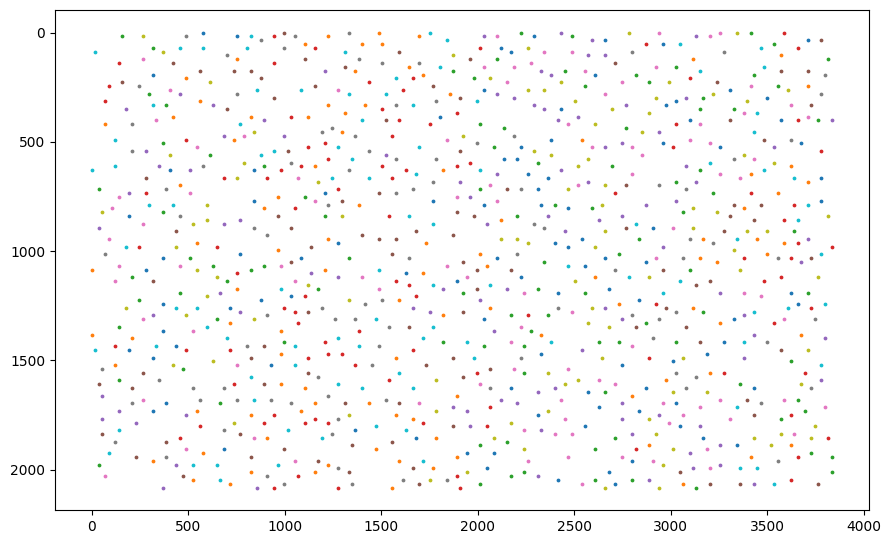

In [16]:


#locations = sp.compute_unit_locations(waveforms)
locations = recording_chunk.get_channel_locations()
print(type(locations))

#np.savetxt("unitloc_10mins.txt",locations)
fig,ax = plt.subplots(figsize=(10.5,6.5))
#sw.plot_probe_map(recording1,ax=ax,with_channel_ids=False)
for x,y in locations:
    ax.scatter(x,y, s=3)
ax.invert_yaxis()
#ax.set_title('Aug02 - 19388')
#plt.savefig('./plots/Aug02_19388_unsorted_units.pdf',format='pdf')

496


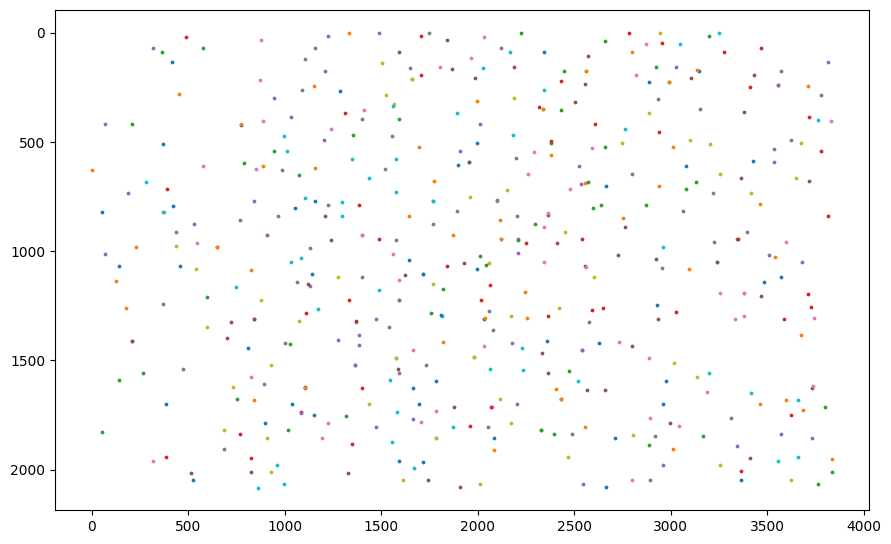

In [17]:
locations = sp.compute_unit_locations(waveforms)
#locations = recording_chunk.get_channel_locations()
print(len(locations))

#np.savetxt("unitloc_10mins.txt",locations)
fig, ax = plt.subplots(figsize=(10.5,6.5))
#sw.plot_probe_map(recording1,ax=ax,with_channel_ids=False)
for x,y in locations:
    ax.scatter(x,y, s=3)

ax.invert_yaxis()
#ax.set_title('Aug 02 - 19388')
#plt.savefig('./plots/Aug02_19388_sorted_units.pdf',format='pdf')

In [ ]:
import spikeinterface_gui
app = spikeinterface_gui.mkQApp() 

# create the mainwindow and show
win = spikeinterface_gui.MainWindow(waveforms)
win.show()
# run the main Qt6 loop
app.exec_()#Need to implement compute noise levels.

In [21]:
len(recording_chunk.channel_ids)

1009

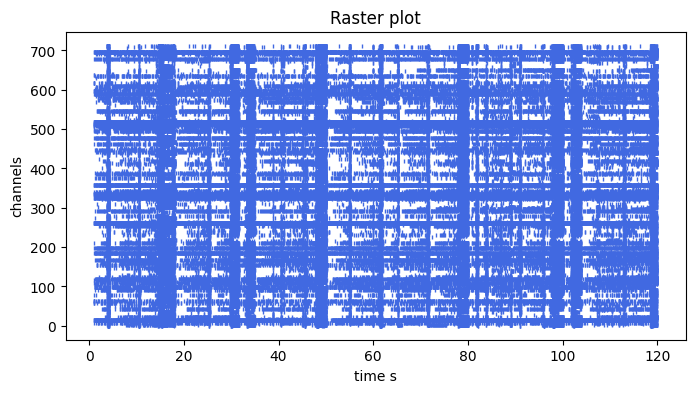

In [18]:
fig, ax1 = plt.subplots(figsize=(8,4))
spike_times = {}
for idx, unit_id in enumerate(waveforms.unit_ids):
    #print(unit_id)
    spike_train = sorting_good.get_unit_spike_train(unit_id,start_frame=1*fs,end_frame=120*fs)
    #print(spike_train)
    if len(spike_train) > 0:
        spike_times[idx] = spike_train / float(fs)
        #print(spike_times[unit_id])
       # print(unit_id*np.ones_like(spike_times[unit_id]))
        # ax1.plot(spike_times[idx],waveforms.channel_ids_to_indices([str(int(extremum_channels_ids[unit_id]))])*np.ones_like(spike_times[idx]),
        #                      marker='|', mew=1, markersize=3,
        #                      ls='',color='royalblue')
        ax1.plot(spike_times[idx],unit_id*np.ones_like(spike_times[idx]),
                             marker='|', mew=1, markersize=3,
                             ls='',color='royalblue')
        ax1.set_title('Raster plot')
        ax1.set_xlabel('time s')
        ax1.set_ylabel("channels")
        #ax1.set_yticks(range(16))
#plt.savefig('./plots/sortedunitsraster.pdf',format='pdf')
                       

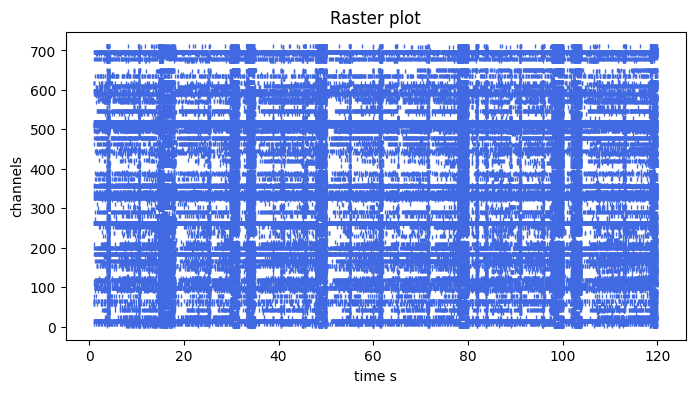

In [19]:
fig, ax1 = plt.subplots(figsize=(8,4))
spike_times = {}
for idx, unit_id in enumerate(non_violated_units):
    #print(unit_id)
    spike_train = sorting_good.get_unit_spike_train(unit_id,start_frame=1*fs,end_frame=120*fs)
    #print(spike_train)
    if len(spike_train) > 0:
        spike_times[idx] = spike_train / float(fs)
        #print(spike_times[unit_id])
       # print(unit_id*np.ones_like(spike_times[unit_id]))
        # ax1.plot(spike_times[idx],waveforms.channel_ids_to_indices([str(int(extremum_channels_ids[unit_id]))])*np.ones_like(spike_times[idx]),
        #                      marker='|', mew=1, markersize=3,
        #                      ls='',color='royalblue')
        ax1.plot(spike_times[idx],unit_id*np.ones_like(spike_times[idx]),
                             marker='|', mew=1, markersize=3,
                             ls='',color='royalblue')
        ax1.set_title('Raster plot')
        ax1.set_xlabel('time s')
        #ax1.set_yticks(range(16))
        ax1.set_ylabel("channels")

In [31]:
unit_locations = sp.compute_unit_locations(waveforms)

print(len(unit_locations))

unit_locations_dict = {}
 
for i in range(0,len(unit_locations)):
    unit_locations_dict[metrics.index[i]] = unit_locations[i]

#filter the unit_locations

filtered_locations = {key : value for key,value in unit_locations_dict.items() if key in non_violated_units}

print(filtered_locations)

496
{2: array([1072.60773773,  649.67693619]), 6: array([1207.85507391,  838.93477224]), 7: array([3377.5, 1190. ]), 12: array([ 122.79462865, 1136.32148542]), 14: array([3780. ,  542.5]), 15: array([1130.77399636, 1160.33781326]), 21: array([3220.76226125,  959.63124548]), 22: array([ 541.11780662, 1082.92671963]), 23: array([1083.22513279, 1032.59636287]), 34: array([ 367.77181481, 1242.84693134]), 40: array([ 139.78568072, 1068.35727711]), 42: array([ 175., 1260.]), 49: array([189.49943474, 736.00017691]), 50: array([2764.35349893,  888.34300286]), 58: array([1489.21015279, 1177.63045837]), 60: array([3675. , 1382.5]), 62: array([2293.2996921 ,  875.26656292]), 64: array([1330., 1225.]), 70: array([3412.86291622,  735.36291622]), 77: array([3533.99529467,  531.09664275]), 78: array([2799.41596582, 1434.85399145]), 84: array([3204.03556099,  508.01184225]), 88: array([3080.6267715 ,  612.65669288]), 90: array([210., 420.]), 91: array([3815.,  840.]), 92: array([ 70., 420.]), 93: arra

In [33]:
corr_channel_ids = []
corr_unit_ids=[]
spike_times =[]
for idx, unit_id in enumerate(non_violated_units):
    #print(unit_id)
    spike_train = sorting_good.get_unit_spike_train(unit_id,start_frame=1*fs,end_frame=300*fs)
    spike_times.extend(spike_train)
    corr_unit_ids.extend([unit_id]*len(spike_train))
    channel = waveforms.channel_ids_to_indices([str(int(extremum_channels_ids[unit_id]))]) 
    corr_channel_ids.extend([channel[0]]*len(spike_train))



In [34]:
data = {
    'spike_times': spike_times,
    'spike_channel_ids': corr_channel_ids,
    'spike_unit_ids': corr_unit_ids
    
}
df = pd.DataFrame(data)

# Sort the DataFrame by 'spike_times' column in ascending order
df_sorted = df.sort_values(by='spike_times')



In [44]:
putative_unit_locX = []
putative_unit_locY = []
for x, y in list(filtered_locations.values()):
    putative_unit_locX.append(x)
    putative_unit_locY.append(y)

In [45]:
import numpy as np
from scipy.io import savemat


spiking_data = {
    'spike_frames': list(df_sorted['spike_times']),
    'spike_units': list(df_sorted['spike_channel_ids'] ),
    'spike_channels': list(df_sorted['spike_unit_ids']),
    'putative_unit_ids':list(filtered_locations.keys()),
    'putative_unit_locX':putative_unit_locX,
    'putative_unit_locY':putative_unit_locY

}

# Save the data as a .mat file
savemat('Syngap3_3Jan_16657.mat', {"spiking_data":spiking_data})

In [ ]:
list(df_sorted['spike_times'])

In [ ]:
t_start = 0 
t_end = int(300*fs)
dt = 1
#initialising the spike train.
units= len(waveforms.unit_ids)
frame_numbers = t_end
spike_array = np.zeros((units,frame_numbers), dtype= int)
for idx, unit_id in enumerate(waveforms.unit_ids):
    spike_train = sorting_good.get_unit_spike_train(unit_id,start_frame=t_start,end_frame=t_end)
    for spike_time in spike_train:
        spike_array[idx,spike_time] = 1

print(spike_array)

spike_array.shape

In [ ]:
np.savez_compressed('spike_array_22Aug.npz',spike_array)

In [ ]:
from scipy.io import savemat
savemat('spikearray_matfile_22aug.mat',{'spikearray':spike_array})

In [ ]:
with np.load('spike_array_compressed_blockactivity.npz') as data:
    decompressed_data = data['arr_0']

print(np.array_equal(spike_array, decompressed_data))


In [11]:

extremum_channels_ids =sp.get_template_extremum_channel(waveforms,peak_sign ='both',mode='at_index')
print(extremum_channels_ids)



{1: '1', 2: '1', 3: '2', 4: '2', 5: '3', 6: '3', 7: '4', 8: '5', 12: '6', 13: '6', 14: '7', 15: '8', 16: '8', 17: '9', 20: '10', 21: '11', 22: '12', 23: '13', 24: '14', 25: '15', 26: '16', 27: '16', 28: '17', 29: '17', 30: '18', 31: '19', 32: '19', 33: '20', 34: '20', 35: '21', 36: '22', 37: '22', 41: '24', 42: '24', 43: '25', 46: '26', 47: '26', 48: '27', 51: '28', 53: '30', 54: '30', 55: '31', 56: '32', 57: '32', 58: '33', 59: '34', 60: '34', 61: '36', 63: '37', 64: '38', 66: '38', 67: '39', 71: '40', 72: '41', 73: '42', 74: '42', 76: '44', 77: '44', 78: '45', 79: '45', 80: '46', 81: '47', 82: '48', 83: '49', 85: '50', 86: '50', 87: '51', 91: '55', 92: '55', 93: '56', 94: '56', 96: '56', 97: '57', 98: '58', 99: '59', 100: '59', 101: '60', 102: '61', 103: '62', 104: '62', 106: '64', 107: '64', 108: '67', 109: '68', 111: '69', 112: '69', 113: '70', 114: '71', 116: '72', 117: '73', 118: '74', 119: '74', 120: '74', 121: '75', 122: '75', 123: '76', 124: '77', 125: '79', 126: '80', 127: '8

[8]


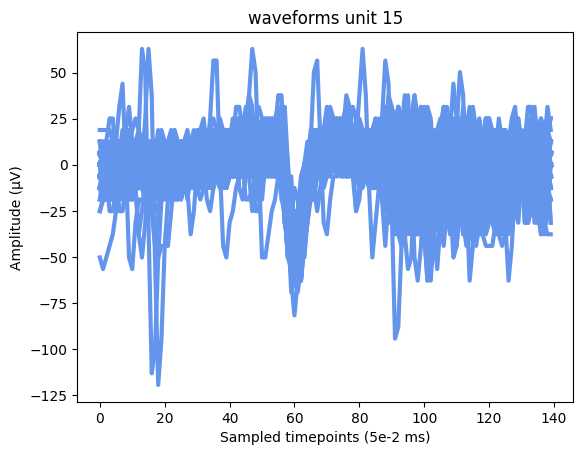

In [17]:

fig, ax = plt.subplots()
for i, unit_id in enumerate([15]):
    
    wf = waveforms.get_waveforms(unit_id)
    
    #print(int(extremum_channels[unit_id]))
    number = waveforms.channel_ids_to_indices([str(int(extremum_channels_ids[unit_id]))])
    print(number)
    ax.plot(wf[:,:, number[0]].T, lw=3,color='cornflowerblue')
    ax.set_title(f"waveforms unit {unit_id}")
    ax.set_ylabel("Amplitude (µV)")
    ax.set_xlabel("Sampled timepoints (5e-2 ms)")
  
plt.savefig('./plots/waveforms_unit12.pdf',format='pdf')

In [ ]:
wf.shape

(140, 1020)
[8]


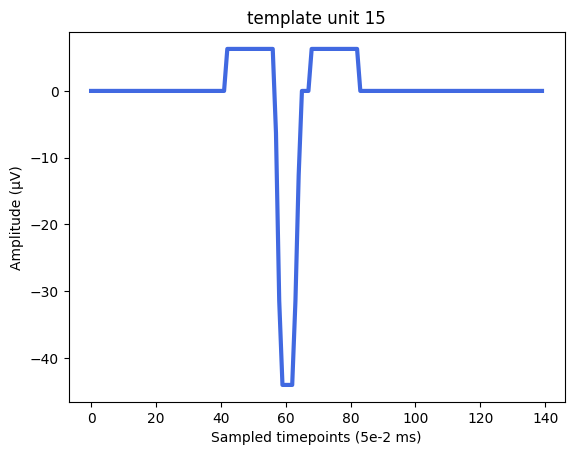

In [18]:




fig, ax = plt.subplots()
for i, unit_id in enumerate([15]):
    
    template = waveforms.get_template(unit_id,mode='median')
    print(template.shape)
    #print(int(extremum_channels[unit_id]))
    number = waveforms.channel_ids_to_indices([str(int(extremum_channels_ids[unit_id]))])
    print(number)
    ax.plot(template[:, number[0]].T, lw=3,color='royalblue')
    ax.set_title(f"template unit {unit_id}")
    ax.set_ylabel("Amplitude (µV)")
    ax.set_xlabel("Sampled timepoints (5e-2 ms)")

plt.savefig('./plots/template_unit12.pdf',format='pdf')

In [ ]:
trace =recording_chunk.get_traces(0,int(0.2*fs))
trace.shape
# plt.figure(figsize=(10,3))
# plt.plot(trace)

In [ ]:
%matplotlib widget
sw.plot_unit_summary(waveforms,unit_id=27)

In [ ]:
%matplotlib widget
sw.plot_unit_templates(waveform_good,unit_ids=[73])

In [ ]:
trough = min(template[:,channel_association_dict[number]])
peak = max(template[:,channel_association_dict[number]])
peak_index = np.where(template[:,channel_association_dict[number]]==peak)[0]
trough_index = np.where(template[:,channel_association_dict[number]]==trough)[0]
trough_to_peak = (peak_index-trough_index)[0]
#index at half peak. 
half_peak_index = np.where(template[:,channel_association_dict[number]]<=0.5*peak)
half_peak_index= half_peak_index[0][np.where(half_peak_index[0]>peak_index)[0][0]]
repol_time = half_peak_index - peak_index[0]


In [ ]:
waveform_good.unit_ids

In [ ]:
def get_channel_association_dict(recording):
    """
    Takes in recording object and gives a channel association dict.
    
    """
    channel_ids = recording.get_channel_ids()

    return {int(y):x for x,y in enumerate(channel_ids) }

def get_template_characteristics(waveforms):

    """
    returns a pd dataframe of unit templates and their characterisitcs Amplitude, trough to peak time, repolarisation time.

    """

    #get unit ids in the waveform object

    unit_ids = waveforms.unit_ids
    #get extremum channels
    extremum_channels_ids =spikeinterface.full.get_template_extremum_channel(waveform_good, peak_sign='both')

    df = []
    for unit_id in unit_ids:
        
        template = waveforms.get_template(unit_id)

        template_segment = template[:,waveforms.channel_ids_to_indices([str(int(extremum_channels[unit_id]))])]
        trough = min(template_segment)
        peak = max(template_segment)
        peak_index = np.where(template_segment==peak)[0]
        trough_index = np.where(template_segment==trough)[0]
        trough_to_peak = (peak_index-trough_index)[0]
        #index at half peak. 
        half_peak_index = np.where(template_segment<=0.5*peak)
        half_peak_index_2= half_peak_index[0][np.where(half_peak_index[0]>peak_index)[0][0]]
        repol_time = half_peak_index_2 - peak_index[0]
        data = {"Unit": unit_id,"Amp":trough[0],"TTP":trough_to_peak,"REP":repol_time}
        df.append(data)
    df = pd.DataFrame(df)
    return df
        
    

In [ ]:

data= get_template_characteristics(waveform_good)
print(data)

In [ ]:
data.to_excel('new_temp_metrics.xlsx')

In [ ]:
%debug

In [ ]:
w = sw.plot_unit_templates(waveform_good, unit_ids=[183],plot_channels=False )

In [ ]:
w = sw.plot_unit_waveforms(waveform_good, unit_ids=[2,4,7])
w = sw.plot_unit_templates(waveform_good, unit_ids=[2,4,7])
w = sw.plot_unit_probe_map(waveform_good, unit_ids=[2,4,7])

In [ ]:
import spikeinterface_gui

In [ ]:
import importlib
importlib.reload(spikeinterface_gui)

In [ ]:




# This creates a Qt app
app = spikeinterface_gui.mkQApp() 

# create the mainwindow and show
win = spikeinterface_gui.MainWindow(waveforms)
win.show()
# run the main Qt6 loop
app.exec_()



In [ ]:
# Create a sample dictionary
my_dict = {'key1': 'value1', 'key2': 'value2', 'key3': 'value1', 'key4': 'value3', 'key5':'value2'}

# Create an empty dictionary to store our results
result_dict = {}

# Loop through each key-value pair in my_dict
for key, value in my_dict.items():
    # Check if the value already exists in result_dict
    if value in result_dict:
        # If it does, append the current key to the list of keys that have the same value
        result_dict[value].append(key)
    else:
        # If it doesn't, create a new entry in result_dict with the value as the key and a list containing the current key
        result_dict[value] = [key]

# Create a list called output that contains only the values from result_dict that have more than one key
output = []
for value in result_dict.values():
    if len(value) > 1:
        output.append(value)

# Print the output to the console
print(output)